In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
%matplotlib inline

dataOld = pd.read_csv("bigfu.csv", sep =';')
dataOld = dataOld.drop(['BenutzerNr', 'FahrzeugNr', 'Strecke', 'KraftstoffNr',  \
                  'Kraftstoff', 'Notiz', 'Verbrauch', 'Sparsam', \
                  'Normal', 'Schnell', 'Winter', 'Sommer', 'Ganzjahr', \
                  'Stadt', 'Land', 'Autobahn', 'Klima', 'Anhaenger'], axis=1)
dataOld.head(10)

,ArtNr,Datum,Laufleistung,Tankmenge,Kosten
0,2,2018-05-02,161152,"20,91","25,07"
1,1,2018-04-19,160309,"39,18","45,80"
2,1,2018-04-12,159559,"37,11","43,75"
3,1,2018-04-01,158783,"25,05","29,28"
4,1,2018-03-28,158231,"45,81","52,64"
5,2,2018-03-27,157746,"20,19","24,41"
6,1,2018-03-20,156987,"20,21","22,61"
7,1,2018-03-06,156605,"34,57","38,68"
8,1,2018-03-04,155956,"26,12","29,76"
9,1,2018-02-19,155498,"38,63","42,45"


In [3]:
dataNew = pd.read_csv("bigfuNew.csv", sep = r'\t', engine='python')
data = pd.concat([dataOld, dataNew])
ordData = data.sort_values(by='Datum')
carInfo = pd.DataFrame(ordData)
carInfo['Datum'] = pd.to_datetime(carInfo.Datum)
carInfo['Tankmenge'] = pd.to_numeric(carInfo.Tankmenge.apply(lambda x: x.replace(',','.')))
carInfo['Kosten'] = pd.to_numeric(carInfo.Kosten.apply(lambda x: x.replace(',','.')))
carInfo['Price'] = (carInfo.Kosten/carInfo.Tankmenge).round(3)
# tank = pd.to_numeric(ordData.Tankmenge.apply(lambda x: x.replace(',','.')))
# kosten = pd.to_numeric(ordData.Kosten.apply(lambda x: x.replace(',','.')))
carInfo = carInfo.set_index('Datum')

dist = []
[dist.append(carInfo.Laufleistung[i+1] - carInfo.Laufleistung[i]) for i in range(0, len(carInfo)-1)]
dist.insert(0,0) # Erstbetankung
carInfo['Distance'] = dist

In [6]:
d2016 = pd.datetime(2016,1,1)
d2017 = pd.datetime(2017,1,1)
d2018 = pd.datetime(2018,1,1)
d2019 = pd.datetime(2019,1,1)
carInfo.head(10)
AvgConsp = sum(carInfo.Tankmenge)/sum(carInfo.Distance)*100
print("Average fuel consumption is %.2f L/100km." % AvgConsp)

Average fuel consumption is 5.04 L/100km.


In [7]:
idx = [i for i in range(0, len(carInfo)) if carInfo.ArtNr[i] == 2] # get index of the not fully fuelled records
idxp1 = [item + 1 for item in idx]
odate = carInfo[carInfo.ArtNr != 1].index # dates of not fully fueled and the first fuel
date = carInfo.Tankmenge.iloc[idxp1].index
nT = [(carInfo.Tankmenge.iloc[i] + carInfo.Tankmenge.iloc[i+1]).round(2) for i in idx]
nD = [(carInfo.Distance.iloc[i] + carInfo.Distance.iloc[i+1]) for i in idx]
Lper100temp = carInfo.drop(['ArtNr', 'Laufleistung', 'Kosten', 'Price'], axis = 1)
for i in range(0, len(date)):
    Lper100temp.at[date[i], 'Tankmenge'] = nT[i]
    Lper100temp.at[date[i], 'Distance'] = nD[i]
Lper100 = Lper100temp.drop(odate)
Lper100['Consumption'] = (Lper100.Tankmenge/Lper100.Distance*100).round(2)
Lper100.head(10)

/home/gong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


,Tankmenge,Distance,Consumption
Datum,,,
2016-02-08,37.99,710,5.35
2016-02-18,42.13,850,4.96
2016-02-25,43.47,799,5.44
2016-03-04,27.71,561,4.94
2016-03-08,52.38,1029,5.09
2016-03-18,23.00,462,4.98
2016-03-23,32.20,644,5.00
2016-03-30,33.66,679,4.96
2016-04-11,32.44,655,4.95


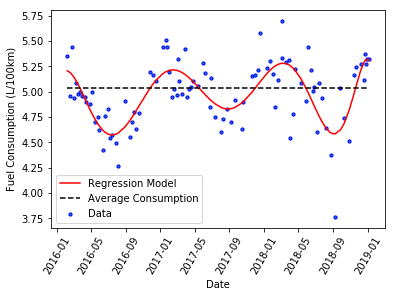

In [10]:
fig = plt.figure()
ax = plt.subplot(111)
X = (Lper100.index - Lper100.index[0]).days # convert date to time interval 
X = X/1000
y = Lper100.iloc[:,2].values
# linear regression
polynomial_features = PolynomialFeatures(degree=9, include_bias=False)
linear_regression = LinearRegression()
pipeline = Pipeline([("polynomial_features", polynomial_features),
                    ("linear_regression", linear_regression)])
pipeline.fit(X[:, np.newaxis], y)
# plot
plt.plot(Lper100.index, pipeline.predict(X[:, np.newaxis]), label="Regression Model", color = 'r')
plt.scatter(Lper100.index, y, edgecolor='b', s=10, label="Data")
Avg = [AvgConsp] * len(Lper100)
plt.plot(Lper100.index, Avg, '--', color = 'k', label = "Average Consumption")
# format
xlabel = ax.get_xticks().tolist()
ax.xaxis_date()
plt.xticks(rotation=60)
plt.legend(loc="best")
plt.xlabel("Date")
plt.ylabel("Fuel Consumption (L/100km)");